In [1]:
import jax
from jaxmarl import make

key = jax.random.PRNGKey(0)
key, key_reset, key_act, key_step = jax.random.split(key, 4)

# Initialise environment.
env = make('MPE_simple_world_comm_v3')

# Reset the environment.
obs, state = env.reset(key_reset)

# Sample random actions.
key_act = jax.random.split(key_act, env.num_agents)
actions = {agent: env.action_space(agent).sample(key_act[i]) for i, agent in enumerate(env.agents)}

# Perform the step transition.
obs, state, reward, done, infos = env.step(key_step, state, actions)

list of agents in environment ['speaker_0', 'listener_0']


/nas/ucb/dylancope/miniconda3/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


example action dict {'speaker_0': Array(1, dtype=int32), 'listener_0': Array(2, dtype=int32)}


/nas/ucb/dylancope/miniconda3/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


Comm active?  True
comm idx [0]


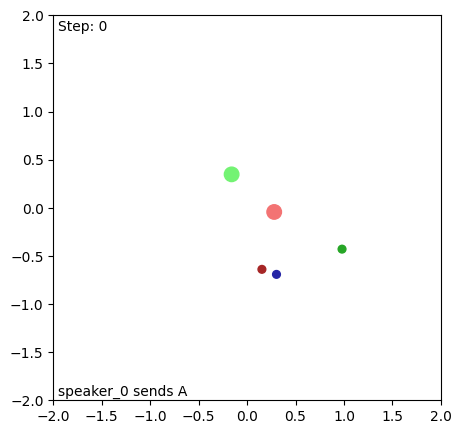

In [1]:
%matplotlib inline

import matplotlib.animation as animation
import jax
from jaxmarl import make
from jaxmarl.environments.mpe import MPEVisualizer

# Parameters + random keys
max_steps = 25
key = jax.random.PRNGKey(0)
key, key_r, key_a = jax.random.split(key, 3)

# Instantiate environment
env = make('MPE_simple_speaker_listener_v4')
obs, state = env.reset(key_r)
print('list of agents in environment', env.agents)

# Sample random actions
key_a = jax.random.split(key_a, env.num_agents)
actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}
print('example action dict', actions)

# Collect trajectory
state_seq = []
for _ in range(max_steps):
    state_seq.append(state)
    # Iterate random keys and sample actions
    key, key_s, key_a = jax.random.split(key, 3)
    key_a = jax.random.split(key_a, env.num_agents)
    actions = {agent: env.action_space(agent).sample(key_a[i]) for i, agent in enumerate(env.agents)}

    # Step environment
    obs, state, rewards, dones, infos = env.step(key_s, state, actions)

# Visualise
viz = MPEVisualizer(env, state_seq)
ani = animation.FuncAnimation(
    viz.fig,
    viz.update,
    frames=len(viz.state_seq),
    blit=False,
    interval=viz.interval,
)

from IPython.display import HTML
HTML(ani.to_html5_video())

In [2]:
obs

{'listener_0': Array([-0.06220087,  0.28859073,  1.4877765 , -1.4714309 ,  2.314898  ,
        -1.2614511 ,  1.6382675 , -1.5237964 ,  1.        ,  0.        ,
        -0.        ], dtype=float32),
 'speaker_0': Array([0.15, 0.65, 0.15], dtype=float32, weak_type=True)}

In [8]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import jaxmarl
from jaxmarl.wrappers.baselines import LogWrapper
from jaxmarl.environments.overcooked import overcooked_layouts
from jaxmarl.viz.overcooked_visualizer import OvercookedVisualizer
import hydra
from omegaconf import OmegaConf

import matplotlib.pyplot as plt

class ActorCritic(nn.Module):
    action_dim: Sequence[int]
    activation: str = "tanh"

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        pi = distrax.Categorical(logits=actor_mean)

        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        critic = activation(critic)
        critic = nn.Dense(
            64, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(critic)
        critic = activation(critic)
        critic = nn.Dense(1, kernel_init=orthogonal(1.0), bias_init=constant(0.0))(
            critic
        )

        return pi, jnp.squeeze(critic, axis=-1)


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

def get_rollout(train_state, config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
    key = jax.random.PRNGKey(0)
    key, key_r, key_a = jax.random.split(key, 3)

    init_x = jnp.zeros(env.observation_space().shape)
    init_x = init_x.flatten()

    network.init(key_a, init_x)
    network_params = train_state.params

    done = False

    obs, state = env.reset(key_r)
    state_seq = [state]
    while not done:
        key, key_a0, key_a1, key_s = jax.random.split(key, 4)

        # obs_batch = batchify(obs, env.agents, config["NUM_ACTORS"])
        # breakpoint()
        obs = {k: v.flatten() for k, v in obs.items()}

        pi_0, _ = network.apply(network_params, obs["agent_0"])
        pi_1, _ = network.apply(network_params, obs["agent_1"])

        actions = {"agent_0": pi_0.sample(seed=key_a0), "agent_1": pi_1.sample(seed=key_a1)}
        # env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)
        # env_act = {k: v.flatten() for k, v in env_act.items()}

        # STEP ENV
        obs, state, reward, done, info = env.step(key_s, state, actions)
        done = done["__all__"]

        state_seq.append(state)

    return state_seq

def batchify(x: dict, agent_list, num_actors):
    x = jnp.stack([x[a] for a in agent_list])
    return x.reshape((num_actors, -1))


def unbatchify(x: jnp.ndarray, agent_list, num_envs, num_actors):
    x = x.reshape((num_actors, num_envs, -1))
    return {a: x[i] for i, a in enumerate(agent_list)}

def make_train(config):
    env = jaxmarl.make(config["ENV_NAME"], **config["ENV_KWARGS"])

    config["NUM_ACTORS"] = env.num_agents * config["NUM_ENVS"]
    config["NUM_UPDATES"] = (
        config["TOTAL_TIMESTEPS"] // config["NUM_STEPS"] // config["NUM_ENVS"]
    )
    config["MINIBATCH_SIZE"] = (
        config["NUM_ACTORS"] * config["NUM_STEPS"] // config["NUM_MINIBATCHES"]
    )

    env = LogWrapper(env)

    def linear_schedule(count):
        frac = 1.0 - (count // (config["NUM_MINIBATCHES"] * config["UPDATE_EPOCHS"])) / config["NUM_UPDATES"]
        return config["LR"] * frac

    def train(rng):

        # INIT NETWORK
        network = ActorCritic(env.action_space().n, activation=config["ACTIVATION"])
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space().shape)

        init_x = init_x.flatten()

        network_params = network.init(_rng, init_x)
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(optax.clip_by_global_norm(config["MAX_GRAD_NORM"]), optax.adam(config["LR"], eps=1e-5))
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # INIT ENV
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0,))(reset_rng)

        # TRAIN LOOP
        def _update_step(runner_state, unused):
            # COLLECT TRAJECTORIES
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # SELECT ACTION
                rng, _rng = jax.random.split(rng)

                obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])

                pi, value = network.apply(train_state.params, obs_batch)
                action = pi.sample(seed=_rng)
                log_prob = pi.log_prob(action)
                env_act = unbatchify(action, env.agents, config["NUM_ENVS"], env.num_agents)

                env_act = {k:v.flatten() for k,v in env_act.items()}

                # STEP ENV
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(env.step, in_axes=(0,0,0))(
                    rng_step, env_state, env_act
                )
                info = jax.tree_map(lambda x: x.reshape((config["NUM_ACTORS"])), info)
                transition = Transition(
                    batchify(done, env.agents, config["NUM_ACTORS"]).squeeze(),
                    action,
                    value,
                    batchify(reward, env.agents, config["NUM_ACTORS"]).squeeze(),
                    log_prob,
                    obs_batch,
                    info

                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )

            # CALCULATE ADVANTAGE
            train_state, env_state, last_obs, rng = runner_state
            last_obs_batch = batchify(last_obs, env.agents, config["NUM_ACTORS"])
            _, last_val = network.apply(train_state.params, last_obs_batch)

            def _calculate_gae(traj_batch, last_val):
                def _get_advantages(gae_and_next_value, transition):
                    gae, next_value = gae_and_next_value
                    done, value, reward = (
                        transition.done,
                        transition.value,
                        transition.reward,
                    )
                    delta = reward + config["GAMMA"] * next_value * (1 - done) - value
                    gae = (
                        delta
                        + config["GAMMA"] * config["GAE_LAMBDA"] * (1 - done) * gae
                    )
                    return (gae, value), gae

                _, advantages = jax.lax.scan(
                    _get_advantages,
                    (jnp.zeros_like(last_val), last_val),
                    traj_batch,
                    reverse=True,
                    unroll=16,
                )
                return advantages, advantages + traj_batch.value

            advantages, targets = _calculate_gae(traj_batch, last_val)

            # UPDATE NETWORK
            def _update_epoch(update_state, unused):
                def _update_minbatch(train_state, batch_info):
                    traj_batch, advantages, targets = batch_info

                    def _loss_fn(params, traj_batch, gae, targets):
                        # RERUN NETWORK
                        pi, value = network.apply(params, traj_batch.obs)
                        log_prob = pi.log_prob(traj_batch.action)

                        # CALCULATE VALUE LOSS
                        value_pred_clipped = traj_batch.value + (
                            value - traj_batch.value
                        ).clip(-config["CLIP_EPS"], config["CLIP_EPS"])
                        value_losses = jnp.square(value - targets)
                        value_losses_clipped = jnp.square(value_pred_clipped - targets)
                        value_loss = (
                            0.5 * jnp.maximum(value_losses, value_losses_clipped).mean()
                        )

                        # CALCULATE ACTOR LOSS
                        ratio = jnp.exp(log_prob - traj_batch.log_prob)
                        gae = (gae - gae.mean()) / (gae.std() + 1e-8)
                        loss_actor1 = ratio * gae
                        loss_actor2 = (
                            jnp.clip(
                                ratio,
                                1.0 - config["CLIP_EPS"],
                                1.0 + config["CLIP_EPS"],
                            )
                            * gae
                        )
                        loss_actor = -jnp.minimum(loss_actor1, loss_actor2)
                        loss_actor = loss_actor.mean()
                        entropy = pi.entropy().mean()

                        total_loss = (
                            loss_actor
                            + config["VF_COEF"] * value_loss
                            - config["ENT_COEF"] * entropy
                        )
                        return total_loss, (value_loss, loss_actor, entropy)

                    grad_fn = jax.value_and_grad(_loss_fn, has_aux=True)
                    total_loss, grads = grad_fn(
                        train_state.params, traj_batch, advantages, targets
                    )
                    train_state = train_state.apply_gradients(grads=grads)
                    return train_state, total_loss

                train_state, traj_batch, advantages, targets, rng = update_state
                rng, _rng = jax.random.split(rng)
                batch_size = config["MINIBATCH_SIZE"] * config["NUM_MINIBATCHES"]
                assert (
                    batch_size == config["NUM_STEPS"] * config["NUM_ACTORS"]
                ), "batch size must be equal to number of steps * number of actors"
                permutation = jax.random.permutation(_rng, batch_size)
                batch = (traj_batch, advantages, targets)
                batch = jax.tree_util.tree_map(
                    lambda x: x.reshape((batch_size,) + x.shape[2:]), batch
                )
                shuffled_batch = jax.tree_util.tree_map(
                    lambda x: jnp.take(x, permutation, axis=0), batch
                )
                minibatches = jax.tree_util.tree_map(
                    lambda x: jnp.reshape(
                        x, [config["NUM_MINIBATCHES"], -1] + list(x.shape[1:])
                    ),
                    shuffled_batch,
                )
                train_state, total_loss = jax.lax.scan(
                    _update_minbatch, train_state, minibatches
                )
                update_state = (train_state, traj_batch, advantages, targets, rng)
                return update_state, total_loss

            update_state = (train_state, traj_batch, advantages, targets, rng)
            update_state, loss_info = jax.lax.scan(
                _update_epoch, update_state, None, config["UPDATE_EPOCHS"]
            )
            train_state = update_state[0]
            metric = traj_batch.info
            rng = update_state[-1]

            runner_state = (train_state, env_state, last_obs, rng)
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = jax.lax.scan(
            _update_step, runner_state, None, config["NUM_UPDATES"]
        )
        return {"runner_state": runner_state, "metrics": metric}

    return train



In [9]:
%matplotlib inline

# set hyperparameters:
config = {
    "LR": 2.5e-4,
    "NUM_ENVS": 16,
    "NUM_STEPS": 128,
    "TOTAL_TIMESTEPS": 5e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "CLIP_EPS": 0.2,
    "ENT_COEF": 0.01,
    "VF_COEF": 0.5,
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "tanh",
    "ENV_NAME": "overcooked",
    "ENV_KWARGS": {
      "layout" : "cramped_room"
    },
    "ANNEAL_LR": True,
    "SEED": 0,
    "NUM_SEEDS": 3
}

config["ENV_KWARGS"]["layout"] = overcooked_layouts[config["ENV_KWARGS"]["layout"]]
rng = jax.random.PRNGKey(config["SEED"])
rngs = jax.random.split(rng, config["NUM_SEEDS"])
with jax.disable_jit(False):
    train_jit = jax.jit(jax.vmap(make_train(config)))
    out = train_jit(rngs)


for i in range(config["NUM_SEEDS"]):
    plt.plot(out["metrics"]["returned_episode_returns"][i].mean(-1).reshape(-1))
plt.xlabel("Update Step")
plt.ylabel("Return")
plt.show()

RuntimeError: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

In [19]:
import jax

a = jax.numpy.array([[ 1.01290589e-03,  2.75272126e-05, -2.69166597e-04,
        -5.58780779e-06],
       [ 2.75272126e-05,  1.34740128e-03, -4.34192721e-06,
        -3.00849575e-04],
       [-2.69166597e-04, -4.34192721e-06,  1.28766222e-04,
         7.41944929e-07],
       [-5.58780779e-06, -3.00849575e-04,  7.41944929e-07,
         7.99537441e-05]])

In [22]:
import numpy
numpy.linalg.cholesky(a)   # ok


array([[ 3.1826183e-02,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 8.6492347e-04,  3.6696773e-02,  0.0000000e+00,  0.0000000e+00],
       [-8.4573952e-03,  8.1017279e-05,  7.5651910e-03,  0.0000000e+00],
       [-1.7557267e-04, -8.1941187e-03, -1.0452791e-05,  3.5748042e-03]],
      dtype=float32)

In [23]:
jax.numpy.linalg.cholesky(a)   # NOk

E0228 22:31:54.971237 1721054 pjrt_stream_executor_client.cc:2804] Execution of replica 0 failed: INTERNAL: cuSolver internal error


XlaRuntimeError: INTERNAL: cuSolver internal error